# Credit Limit Assessment (CLA)

In [1]:
import random
from random import randrange
from datetime import datetime
from datetime import timedelta
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import model_from_json

## Data Simulation Functions

In [2]:
def DS_ACTIVATED_CL(CUSTOMER_TYPE, CUSTOMER_SUB_SEGMENT, NUMBER_LINES):
  NUMBER_LINES = int (NUMBER_LINES)
  if CUSTOMER_TYPE == 'Business Customer Account':
    max = 1000
  else:
    max = 100

  if CUSTOMER_SUB_SEGMENT == 'Fixed & Mobile UAE':
    min = max // 2
  elif CUSTOMER_SUB_SEGMENT == 'Mobile UAE':
    min = max // 3
  elif CUSTOMER_SUB_SEGMENT == 'Fixed UAE':
    min = max // 4
  elif CUSTOMER_SUB_SEGMENT == 'Fixed & Mobile Expat':
    min = max // 5 
  else:
    min = 0
  cl = random.randint(min, max) + NUMBER_LINES * 10
  return str(cl)


In [3]:
def DS_NUMBER_LINES(CUSTOMER_TYPE):
  if CUSTOMER_TYPE == 'Business Customer Account':
    max = 300
  else:
    max = 10
  min = 0
  n_lines = random.randint(min, max)
  return str(n_lines)  


In [4]:
def DS_CUSTOMER_TYPE():
  DS_LIST = ['Residential Customer Account', 'Business Customer Account']
  return random.sample(DS_LIST, 1)[0]
# DS_CUSTOMER_TYPE()

In [5]:
def DS_CUSTOMER_SUB_SEGMENT():
  DS_LIST = ['Fixed & Mobile Expat', 'Mobile Expat', 'Fixed Expat', 'Fixed & Mobile UAE', 'Mobile UAE', 'Fixed UAE']
  return random.sample(DS_LIST, 1)[0]
# DS_CUSTOMER_SUB_SEGMENT()

In [6]:
def head_line():
  return 'NUMBER_LINES,CUSTOMER_TYPE,CUSTOMER_SUB_SEGMENT,ACTIVATED_CL'

In [7]:
def df_lines(num_lines):
  myfile = open('CLA_001.csv', 'w')
  df_str = '' + head_line() + '\n'
  myfile.writelines(df_str)
  for _ in range(num_lines):
    CUSTOMER_TYPE = DS_CUSTOMER_TYPE()
    CUSTOMER_SUB_SEGMENT = DS_CUSTOMER_SUB_SEGMENT()
    NUMBER_LINES = DS_NUMBER_LINES(CUSTOMER_TYPE)
    ACTIVATED_CL = DS_ACTIVATED_CL(CUSTOMER_TYPE, CUSTOMER_SUB_SEGMENT, NUMBER_LINES)

    df_str = '' + NUMBER_LINES \
      + ',' + CUSTOMER_TYPE \
      + ',' + CUSTOMER_SUB_SEGMENT \
      + ',' + ACTIVATED_CL \
      + '\n'
    myfile.writelines(df_str)
  myfile.close()

##DF Simulation

In [8]:
df_str = df_lines(300000)

## Exploring and Processing the Dataset

### Read and split our dataset into the input features

In [9]:
# Using Pandas
df = pd.read_csv('/content/CLA_001.csv') # This is the path where you put the data file
print(df.shape) # Quantity and number of the features

(300000, 4)


### Analysis and selection of necessary features

In [10]:
df.head()

,NUMBER_LINES,CUSTOMER_TYPE,CUSTOMER_SUB_SEGMENT,ACTIVATED_CL
0,6,Residential Customer Account,Fixed Expat,143
1,5,Residential Customer Account,Fixed & Mobile Expat,118
2,52,Business Customer Account,Fixed & Mobile Expat,912
3,56,Business Customer Account,Fixed Expat,1060
4,27,Business Customer Account,Fixed Expat,702


In [11]:
print(df.columns) #Show data column names

Index(['NUMBER_LINES', 'CUSTOMER_TYPE', 'CUSTOMER_SUB_SEGMENT',
       'ACTIVATED_CL'],
      dtype='object')


In [12]:
df.dtypes

NUMBER_LINES             int64
CUSTOMER_TYPE           object
CUSTOMER_SUB_SEGMENT    object
ACTIVATED_CL             int64
dtype: object

In [13]:
# max value in NUMBER_LINES
MAX_NUMBER_LINES = df['NUMBER_LINES'].max()
print(f'MAX_NUMBER_LINES={MAX_NUMBER_LINES}')

MAX_NUMBER_LINES=300


## Data Frame transformation

In [14]:
# Customizing column numbers: for not depending on the order of the columns in the table
COL_NUMBER_LINES         = df.columns.get_loc('NUMBER_LINES')
COL_CUSTOMER_TYPE        = df.columns.get_loc('CUSTOMER_TYPE')
COL_CUSTOMER_SUB_SEGMENT = df.columns.get_loc('CUSTOMER_SUB_SEGMENT')
COL_ACTIVATED_CL         = df.columns.get_loc('ACTIVATED_CL')

#### Categorization of enumerated types

In [15]:
# CUSTOMER_TYPE Classes
CUSTOMER_TYPE_class = [0, 
                    {'Business Customer Account	'   : 0,
                     'Residential Customer Account' : 1
                    }]
# CUSTOMER_SUB_SEGMENT Classes
CUSTOMER_SUB_SEGMENT_class = [0, 
              {'Fixed & Mobile Expat' : 0,
               'Mobile Expat'         : 1,
               'Fixed Expat'          : 2,
               'Fixed & Mobile UAE'   : 3,
               'Mobile UAE'           : 4,
               'Fixed UAE'            : 5
                             }]

In [16]:
# Calculating counters for the splitted data
for class_desc in [CUSTOMER_TYPE_class,
                   CUSTOMER_SUB_SEGMENT_class]:
    if isinstance(class_desc[1], list):
        class_desc[0] = len(class_desc[1]) + 1
    else:
        class_desc[0] = max(class_desc[1].values()) + 1

In [17]:
CUSTOMER_SUB_SEGMENT_class

[6,
 {'Fixed & Mobile Expat': 0,
  'Mobile Expat': 1,
  'Fixed Expat': 2,
  'Fixed & Mobile UAE': 3,
  'Mobile UAE': 4,
  'Fixed UAE': 5}]

In [18]:
# General function to convert string to multi-vector
def str_to_multi(arg, class_dict):
    # Определение размерности выходного вектора
    num_classes = class_dict[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)
    
    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in class_dict[1].items():
      # print(f'value={value} cls={cls}')
      if value == arg:
          result[cls] = 1.

    return result

def extract_CUSTOMER_SUB_SEGMENT_to_multi(arg):
  return str_to_multi(arg, CUSTOMER_SUB_SEGMENT_class)

def extract_CUSTOMER_TYPE_to_multi(arg):
  return str_to_multi(arg, CUSTOMER_TYPE_class)

#### Now enumerated types looks like these:

In [19]:
CUSTOMER_SS = 'Fixed & Mobile UAE'
extract_CUSTOMER_SUB_SEGMENT_to_multi(CUSTOMER_SS)

array([0., 0., 0., 1., 0., 0.])

In [20]:
CUSTOMER_TYPE = 'Residential Customer Account'
extract_CUSTOMER_TYPE_to_multi(CUSTOMER_TYPE)

array([0., 1.])

#### Numerical data scaling

In [21]:
def extract_NUMBER_LINES_Category(arg, MAX_NUMBER_LINES):
  NUMBER_LINES = utils.to_categorical(arg, MAX_NUMBER_LINES+1) #Converting to a category
  return NUMBER_LINES

In [22]:
# Example
extract_NUMBER_LINES_Category(5,MAX_NUMBER_LINES)

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

#### Creating train data

In [23]:
def extract_row_data(row):
  ACTIVATED_CL = int(row[COL_ACTIVATED_CL])
  ACTIVATED_CL_vec = np.array([ACTIVATED_CL])

  NUMBER_LINES = int(row[COL_NUMBER_LINES])
  # NUMBER_LINES_vec = np.array([NUMBER_LINES])
  NUMBER_LINES_vec = extract_NUMBER_LINES_Category(NUMBER_LINES, MAX_NUMBER_LINES)
  
  CUSTOMER_TYPE_ohe = extract_CUSTOMER_TYPE_to_multi(row[COL_CUSTOMER_TYPE])
  CUSTOMER_SUB_SEGMENT_ohe = extract_CUSTOMER_SUB_SEGMENT_to_multi(row[COL_CUSTOMER_SUB_SEGMENT])

  # Combining all input data into one common vector
  x_data = np.hstack([NUMBER_LINES_vec, 
                      CUSTOMER_TYPE_ohe,
                      CUSTOMER_SUB_SEGMENT_ohe])
  return x_data, ACTIVATED_CL_vec

# Creating train data
def construct_train_data(row_list):
    x_data = []
    y_data = []
    
    for row in row_list:
        x, y = extract_row_data(row)
        if y[0] > 0:                      
            x_data.append(x)
            y_data.append(y)

    return np.array(x_data), np.array(y_data)


In [24]:
# Creating train data  
x_train, y_train = construct_train_data(df.values)

#### Data normalization

In [25]:
# To normalize the data is using StandardScaler
y_scaler = StandardScaler()
y_train_scaler = y_scaler.fit_transform(y_train)

In [26]:
# This file must be saved to restore the data to its original scale
joblib.dump(y_scaler, 'std_scaler.bin', compress=True)

['std_scaler.bin']

In [27]:
# Normalization check
print(y_train.shape)
print(f'Original value CL:  {y_train [1, 0]}')
print(f'Normalized value CL: {y_train_scaler [1, 0]}')

# Boundaries of unnormalized and normalized data
print(y_train_scaler.mean(), y_train_scaler.std())
print(y_train.mean(), y_train.std())

(299960, 1)
Original value CL:  118
Normalized value CL: -0.8358466895293525
2.3616852498760498e-17 1.0
1108.2397419655954 1184.7145587466266


In [28]:
# Next, we use only normalized data
y_train = y_train_scaler 
# As a result, we get the following datasets:
print(x_train.shape) 
print(y_train.shape)
print(type(x_train), type(y_train))

# Example of processed data
n = 0 
print(x_train[n])
print(y_train[n])

(299960, 309)
(299960, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0

## Neural Network architecture and hyperparameters

### Model Creating

In [29]:
# The function of drawing the graph of the training history
def plot_history(history):
    plt.plot(history.history['mae'], 
            label='Average absolute error on the training set')
    plt.plot(history.history['val_mae'], 
            label='Average absolute error on the validation set')
    plt.xlabel('Age of Learning')
    plt.ylabel('Average absolute error')
    plt.legend()
    plt.show()

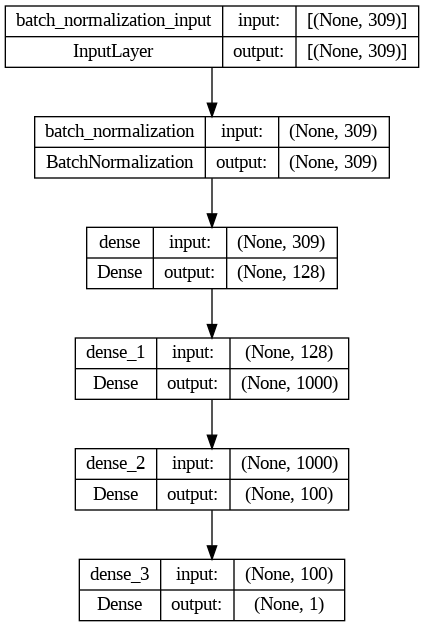

In [30]:
# Model building
model = Sequential()
model.add(BatchNormalization(input_dim=x_train.shape[1]))
model.add(Dense(128, activation='relu'))
model.add(Dense(1000, activation='tanh'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='linear'))

utils.plot_model(model, show_shapes=True)

### Model Training

Epoch 1/50
996/996 [==============================] - 11s 5ms/step - loss: 0.2692 - mae: 0.3827 - val_loss: 0.0795 - val_mae: 0.1919
Epoch 2/50
996/996 [==============================] - 5s 5ms/step - loss: 0.0510 - mae: 0.1592 - val_loss: 0.0762 - val_mae: 0.1828
Epoch 3/50
996/996 [==============================] - 4s 5ms/step - loss: 0.0375 - mae: 0.1380 - val_loss: 0.0811 - val_mae: 0.1811
Epoch 4/50
996/996 [==============================] - 5s 5ms/step - loss: 0.0348 - mae: 0.1321 - val_loss: 0.0703 - val_mae: 0.1767
Epoch 5/50
996/996 [==============================] - 4s 4ms/step - loss: 0.0330 - mae: 0.1280 - val_loss: 0.0695 - val_mae: 0.1692
Epoch 6/50
996/996 [==============================] - 4s 4ms/step - loss: 0.0311 - mae: 0.1239 - val_loss: 0.0625 - val_mae: 0.1607
Epoch 7/50
996/996 [==============================] - 5s 5ms/step - loss: 0.0298 - mae: 0.1208 - val_loss: 0.0543 - val_mae: 0.1520
Epoch 8/50
996/996 [==============================] - 4s 4ms/step - loss: 0

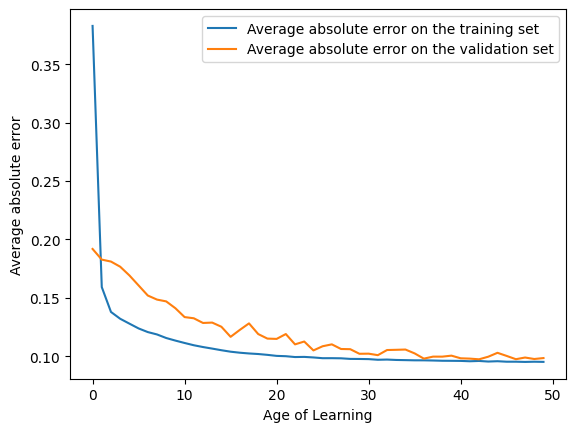

In [31]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])
# Model Training
history = model.fit(x_train, 
                    y_train, 
                    epochs=50, 
                    batch_size=256,
                    validation_split=0.15, 
                    verbose=1)

plot_history(history)

### Model Prediction Estimation

In [32]:
# Checking NN - prediction on the training set
pred = model.predict(x_train)

# Calculation of the mean error 
print(mean_absolute_error(pred, y_train)) 

9374/9374 [==============================] - 16s 2ms/step
0.09808457670324759


### Saving the best model

In [33]:
# Save the model
# Serialization to JSON
model_json = model.to_json()
with open("/content/model.json", "w") as json_file:
    json_file.write(model_json)
# Serialization model to HDF5 format
model.save_weights("/content/model.h5")
print("Model saved")

Model saved


## Deployment and Integration

### Loading saved model 

In [34]:
# Load the saved model
json_file = open('/content/model.json','r') 
loaded_model_json = json_file.read() 
json_file.close() 
loaded_model = model_from_json(loaded_model_json) 
loaded_model.summary()
loaded_model.load_weights("/content/model.h5") 
print("Model loaded from disk")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 309)              1236      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               39680     
                                                                 
 dense_1 (Dense)             (None, 1000)              129000    
                                                                 
 dense_2 (Dense)             (None, 100)               100100    
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 270,117
Trainable params: 269,499
Non-trainable params: 618
________________________________________________

### Model validation on new data

In [35]:
def data_preparation(NUMBER_LINES, CUSTOMER_TYPE, CUSTOMER_SUB_SEGMENT):
  NUMBER_LINES_vec = extract_NUMBER_LINES_Category(NUMBER_LINES, MAX_NUMBER_LINES)
  CUSTOMER_TYPE_ohe = extract_CUSTOMER_TYPE_to_multi(CUSTOMER_TYPE)
  CUSTOMER_SUB_SEGMENT_ohe = extract_CUSTOMER_SUB_SEGMENT_to_multi(CUSTOMER_SUB_SEGMENT)
  x_data = np.hstack([NUMBER_LINES_vec, 
                        CUSTOMER_TYPE_ohe,
                        CUSTOMER_SUB_SEGMENT_ohe])
  # print(type(x_data))
  # print(x_data.shape)
  x_data = x_data.reshape(1, x_data.shape[0])
  # print(type(x_data))
  # print(x_data.shape)
  return x_data

In [38]:
NUMBER_LINES = 10
CUSTOMER_TYPE = 'Residential Customer Account'
CUSTOMER_SUB_SEGMENT = 'Fixed UAE'

x_data = data_preparation(NUMBER_LINES, CUSTOMER_TYPE, CUSTOMER_SUB_SEGMENT)
pred = loaded_model.predict(x_data)             
# print(type(pred))
# print(pred.shape)
pred = y_scaler.inverse_transform(pred)
cla = int(pred[0][0])
print (cla)

1/1 [==============================] - 0s 24ms/step
131


In [39]:
NUMBER_LINES = 100
CUSTOMER_TYPE = 'Business Customer Account'
CUSTOMER_SUB_SEGMENT = 'Fixed UAE'

x_data = data_preparation(NUMBER_LINES, CUSTOMER_TYPE, CUSTOMER_SUB_SEGMENT)
pred = loaded_model.predict(x_data)             
# print(type(pred))
# print(pred.shape)
pred = y_scaler.inverse_transform(pred)
cla = int(pred[0][0])
print (cla)

1/1 [==============================] - 0s 20ms/step
1604
